This notebook is meant to be used to merge the various csv files into a single, coherent one. There will be a seperate notebook to run the dataframes to create one single visualization for all five samples (there is a visualization at the bottom if you want to check out your data). 


# Importing Libraries
you need to run this everytime when you open this file

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 12, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

import warnings
warnings.filterwarnings('ignore')

# Loading the dataframes
It may be that you have multiple csv files for temperature or for the heartrate. This next code is meant to help you load and merge the files. 

(Note: this code assumes that the amount of columns and their names are the same.)

## Temperature

In [2]:
df_t1 = pd.read_csv('./datasets/temperature1.csv', error_bad_lines=False) #Loading temp csv file 1 - make sure the location and name is correct. 

df_t2 = pd.read_csv('./datasets/temperature2.csv', error_bad_lines=False) #loading temp csv file 2 - make sure the location and name is correct.  

#if you have more, duplicate the line above and change the csv location and name of dataframe
#if you only have one, comment out the line with df_t2 in it

df_temporary = pd.concat([df_t1, df_t2]) #if you only have one csv for temperature, comment this line out

df_temp=pd.DataFrame()

df_temp['Date/Time']=df_temporary['Date/Time'] #if you only have one csv for temperature, replace df_temporary with df_t1
df_temp['Temperature']=df_temporary[' Temperature'] #if you only have one csv for temperature, replace df_temporary with df_t1

df_temp.head() #check if it is correct

b'Skipping line 4: expected 11 fields, saw 16\nSkipping line 6: expected 11 fields, saw 45\n'


,Date/Time,Temperature
0,15-5-2022 T 20:48:15,25.4
1,15-5-2022 T 20:48:26,25.3
2,15-5-2022 T 20:48:37,25.3
3,15-5-2022 T 20:48:48,25.3
4,15-5-2022 T 20:48:59,25.2


## Heartrate

In [3]:
df_h1 = pd.read_csv('./datasets/heart1.csv') #Loading heart csv file 1 - make sure the location and name is correct. 

df_h2 = pd.read_csv('./datasets/heart2.csv') #loading heart csv file 2 - make sure the location and name is correct.  

#if you have more, duplicate the line above and change the csv location and name of dataframe
#if you only have one, comment out the line with df_h2 in it

df_heart = pd.concat([df_h1, df_h2]) #merging heartrate dataframes, if you only have one csv file, comment this out

# df_heart=df_h1 #if you have only one csv file, comment this in

df_heart.head()

,date,time,heartRate
0,14/05/2022,00:00,74
1,14/05/2022,00:01,78
2,14/05/2022,00:02,79
3,14/05/2022,00:03,79
4,14/05/2022,00:04,90


# Cleaning and grouping the datasets

## Temperature

I've been measuring the temperature more frequently than 1 min so this code will also help group the temperature to every minute. 

In [4]:
df_temp=df_temp[df_temp["Date/Time"].str.contains("Date/Time")==False] #should remove extra column names in the rows

df_temp['Date/Time'] = pd.to_datetime(df_temp['Date/Time']) #converting date and time to the correct format

df_temp.dropna(inplace=True) #dropping invalid values

df_temp['Temperature']=pd.to_numeric(df_temp['Temperature'], errors='coerce')

df_temp=df_temp.groupby(pd.Grouper(key='Date/Time', axis=0, freq='1min')).mean() #groups to 1 min

df_temp.head() #check to see if it is set correctly

,Temperature
Date/Time,
2022-05-15 20:48:00,25.30
2022-05-15 20:49:00,25.16
2022-05-15 20:50:00,25.05
2022-05-15 20:51:00,25.00
2022-05-15 20:52:00,24.90


## Heartrate

In [5]:
df_heart.dropna(inplace=True) #dropping invalid values

df_heart['Date/Time']=pd.to_datetime(df_heart['date'] + ' ' + df_heart['time']) #Combining date and time and formatting

df_heart.drop(columns=['date', 'time'], inplace=True) #Removing duplicated date and time columns

df_heart=df_heart.groupby(pd.Grouper(key='Date/Time', axis=0, freq='1min')).sum() #making sure it is per minute

df_heart = df_heart[df_heart.heartRate != 0] #removed values with heartrate values 0

df_heart.head()

,heartRate
Date/Time,
2022-01-06 00:15:00,65
2022-01-06 00:16:00,75
2022-01-06 00:20:00,90
2022-01-06 00:29:00,87
2022-01-06 00:30:00,92


# Merging temperature and heartrate dataframe

In [6]:
df_final=pd.merge(df_temp, df_heart, on='Date/Time') #merging on column Date/Time (this also turns it into the index I think)
df_final.dropna(inplace=True) #dropping any additional invalid values
df_final.columns = ['I:Temperature', 'D:Heartrate'] #renaming columns
df_final.head() #check if it is correct

,I:Temperature,D:Heartrate
Date/Time,,
2022-05-15 23:30:00,24.1,176
2022-05-15 23:31:00,24.0,184
2022-05-15 23:32:00,24.0,168
2022-05-15 23:33:00,24.0,184
2022-05-15 23:34:00,24.0,186


# Removing daytime data


In [7]:
start = datetime.strptime('01:00:00', '%H:%M:%S').time() 
end = datetime.strptime('06:00:00', '%H:%M:%S').time() 
df_final['Date/Time'] = df_final.index
df_final = df_final[df_final['Date/Time'].dt.time.between(start, end)] 
df_final.drop(columns=['Date/Time'], inplace=True) #Removing duplicated date and time column

df_final.head() #check if it is correct

,I:Temperature,D:Heartrate
Date/Time,,
2022-05-16 01:00:00,23.5,168
2022-05-16 01:01:00,23.5,162
2022-05-16 01:02:00,23.5,166
2022-05-16 01:03:00,23.5,168
2022-05-16 01:04:00,23.5,156


# Exporting dataframe (and create plot)
This will export the necessary csv to be reimported with all the other samples to create a single file (plus it creates a neat diagram)

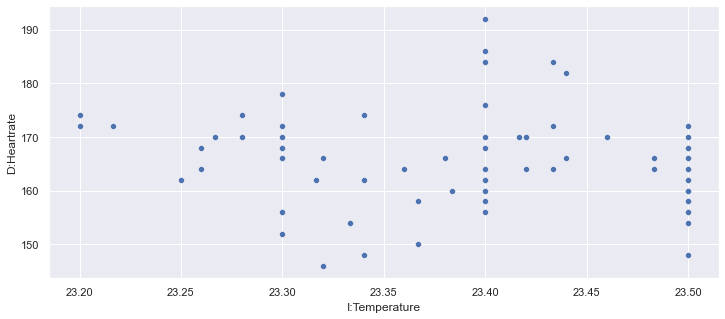

In [8]:
sns.scatterplot(data=df_final, x='I:Temperature', y='D:Heartrate') #the plot

df_final.to_csv('./datasets/final.csv')  #exporting